In [20]:
!pip install 'sagemaker[local]' --upgrade

In [21]:
!sudo service docker restart

Stopping docker: [  OK  ]
Starting docker:	.[  OK  ]


In [39]:
!docker rmi -f $(docker images -a -q)

Untagged: 763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-training:2.1.0-cpu-py3
Untagged: 763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-training@sha256:4911ac31a130c68a2f92b72dd81d22bd02b542cc549c5652f22c1f24e702eaf5
Deleted: sha256:88ccf0c00d27088646aaa5b8e69c7a9d00753269853edf84288f4f5bf8a9b76a
Untagged: 763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-inference:2.1.0-cpu
Untagged: 763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-inference@sha256:866d9df3bb47b1660a8c0aa46c794e39177a25bf1ca969f84dfc315853af1c36
Deleted: sha256:98d7667cfdef6d9e98fb718c966e8f3d60b330b8682822f1aec2d5448e2eb939


In [22]:
s3_bucket = 'sagemaker-cookbook-bucket'
prefix = 'chapter03'

In [23]:
train_s3 = f"s3://{s3_bucket}/{prefix}/synthetic/training_data.csv" 
val_s3 = f"s3://{s3_bucket}/{prefix}/synthetic/validation_data.csv" 
s3_output_location = f"s3://{s3_bucket}/{prefix}/output/tensorflow/"

In [24]:
from sagemaker.inputs import TrainingInput
    
train_input = TrainingInput(train_s3, content_type="text/csv")
val_input = TrainingInput(val_s3, content_type="text/csv")

In [25]:
import os
import sagemaker
from sagemaker import get_execution_role
from sagemaker.local import LocalSession

sagemaker_session = LocalSession()
sagemaker_session.config = {'local': {'local_code': True}}

role = get_execution_role()

In [26]:
from sagemaker.tensorflow.estimator import TensorFlow

estimator = TensorFlow(entry_point='tensorflow_script.py',
                       output_path=s3_output_location,
                       role=role,
                       sesion=sagemaker_session,
                       instance_count=1,
                       instance_type='local',
                       framework_version='2.1.0',
                       py_version='py3')

In [28]:
estimator.fit({'train': train_input, 'validation': val_input})

Creating 71rxqjglk9-algo-1-3w56q ... 
Creating 71rxqjglk9-algo-1-3w56q ... done
Attaching to 71rxqjglk9-algo-1-3w56q
71rxqjglk9-algo-1-3w56q | 2021-04-08 19:26:50,371 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
71rxqjglk9-algo-1-3w56q | 2021-04-08 19:26:50,377 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
71rxqjglk9-algo-1-3w56q | 2021-04-08 19:26:50,601 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
71rxqjglk9-algo-1-3w56q | 2021-04-08 19:26:50,619 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
71rxqjglk9-algo-1-3w56q | 2021-04-08 19:26:50,636 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
71rxqjglk9-algo-1-3w56q | 2021-04-08 19:26:50,648 sagemaker-containers INFO     Invoking user script
71rxqjglk9-algo-1-3w56q | 
71rxqjglk9-algo-1-3w56q | Training Env:
71rxqjglk9-algo-1-3w56q | 
71rxqjglk9-algo-1-3w56q | {
71rxqjglk9-al

71rxqjglk9-algo-1-3w56q | Model: "sequential"
71rxqjglk9-algo-1-3w56q | _________________________________________________________________
71rxqjglk9-algo-1-3w56q | Layer (type)                 Output Shape              Param #   
71rxqjglk9-algo-1-3w56q | =================================================================
71rxqjglk9-algo-1-3w56q | dense (Dense)                (None, 100)               200       
71rxqjglk9-algo-1-3w56q | _________________________________________________________________
71rxqjglk9-algo-1-3w56q | dense_1 (Dense)              (None, 100)               10100     
71rxqjglk9-algo-1-3w56q | _________________________________________________________________
71rxqjglk9-algo-1-3w56q | dense_2 (Dense)              (None, 100)               10100     
71rxqjglk9-algo-1-3w56q | _________________________________________________________________
71rxqjglk9-algo-1-3w56q | dense_3 (Dense)              (None, 100)               10100     
71rxqjglk9-algo-1-3w56q | ________

640/640 [==============================] - 0s 50us/sample - loss: 456964.9043 - val_loss: 415717.4375
71rxqjglk9-algo-1-3w56q | Epoch 40/1000
640/640 [==============================] - 0s 54us/sample - loss: 455875.2949 - val_loss: 412265.4688
71rxqjglk9-algo-1-3w56q | Epoch 41/1000
640/640 [==============================] - 0s 53us/sample - loss: 456811.7637 - val_loss: 411804.2500
71rxqjglk9-algo-1-3w56q | Epoch 42/1000
640/640 [==============================] - 0s 51us/sample - loss: 456502.0312 - val_loss: 413898.9375
71rxqjglk9-algo-1-3w56q | Epoch 43/1000
640/640 [==============================] - 0s 53us/sample - loss: 457081.3848 - val_loss: 416204.7188
71rxqjglk9-algo-1-3w56q | Epoch 44/1000
640/640 [==============================] - 0s 52us/sample - loss: 456642.2422 - val_loss: 415391.9375
71rxqjglk9-algo-1-3w56q | Epoch 45/1000
640/640 [==============================] - 0s 51us/sample - loss: 456339.4980 - val_loss: 413140.5938
71rxqjglk9-algo-1-3w56q | Epoch 46/1000
640/64

640/640 [==============================] - 0s 53us/sample - loss: 459893.1875 - val_loss: 421473.0938
71rxqjglk9-algo-1-3w56q | Epoch 100/1000
640/640 [==============================] - 0s 49us/sample - loss: 456962.2031 - val_loss: 412173.7188
71rxqjglk9-algo-1-3w56q | Epoch 101/1000
640/640 [==============================] - 0s 54us/sample - loss: 455949.6191 - val_loss: 410840.4688
71rxqjglk9-algo-1-3w56q | Epoch 102/1000
640/640 [==============================] - 0s 50us/sample - loss: 457779.5762 - val_loss: 410927.5000
71rxqjglk9-algo-1-3w56q | Epoch 103/1000
640/640 [==============================] - 0s 50us/sample - loss: 456418.5430 - val_loss: 412823.5000
71rxqjglk9-algo-1-3w56q | Epoch 104/1000
640/640 [==============================] - 0s 50us/sample - loss: 455853.5918 - val_loss: 413469.5312
71rxqjglk9-algo-1-3w56q | Epoch 105/1000
640/640 [==============================] - 0s 49us/sample - loss: 455406.9277 - val_loss: 417472.3750
71rxqjglk9-algo-1-3w56q | Epoch 106/1000

640/640 [==============================] - 0s 56us/sample - loss: 457429.3047 - val_loss: 410702.0938
71rxqjglk9-algo-1-3w56q | Epoch 155/1000
640/640 [==============================] - 0s 53us/sample - loss: 456512.1465 - val_loss: 416202.5625
71rxqjglk9-algo-1-3w56q | Epoch 156/1000
640/640 [==============================] - 0s 52us/sample - loss: 459516.1719 - val_loss: 421547.5625
71rxqjglk9-algo-1-3w56q | Epoch 157/1000
640/640 [==============================] - 0s 52us/sample - loss: 457662.6875 - val_loss: 413935.0625
71rxqjglk9-algo-1-3w56q | Epoch 158/1000
640/640 [==============================] - 0s 51us/sample - loss: 454510.6602 - val_loss: 411451.1562
71rxqjglk9-algo-1-3w56q | Epoch 159/1000
640/640 [==============================] - 0s 50us/sample - loss: 455598.8184 - val_loss: 410239.0938
71rxqjglk9-algo-1-3w56q | Epoch 160/1000
640/640 [==============================] - 0s 51us/sample - loss: 455622.4453 - val_loss: 412085.9375
71rxqjglk9-algo-1-3w56q | Epoch 161/1000

640/640 [==============================] - 0s 56us/sample - loss: 456291.8887 - val_loss: 411453.9375
71rxqjglk9-algo-1-3w56q | Epoch 211/1000
640/640 [==============================] - 0s 51us/sample - loss: 453617.5762 - val_loss: 411999.8438
71rxqjglk9-algo-1-3w56q | Epoch 212/1000
640/640 [==============================] - 0s 50us/sample - loss: 454122.3359 - val_loss: 412414.2500
71rxqjglk9-algo-1-3w56q | Epoch 213/1000
640/640 [==============================] - 0s 50us/sample - loss: 452302.2188 - val_loss: 407613.6250
71rxqjglk9-algo-1-3w56q | Epoch 214/1000
640/640 [==============================] - 0s 50us/sample - loss: 452459.4668 - val_loss: 407826.4375
71rxqjglk9-algo-1-3w56q | Epoch 215/1000
640/640 [==============================] - 0s 51us/sample - loss: 453620.9961 - val_loss: 407611.5000
71rxqjglk9-algo-1-3w56q | Epoch 216/1000
640/640 [==============================] - 0s 52us/sample - loss: 451653.6543 - val_loss: 409098.6562
71rxqjglk9-algo-1-3w56q | Epoch 217/1000

640/640 [==============================] - 0s 56us/sample - loss: 449811.5879 - val_loss: 409871.8125
71rxqjglk9-algo-1-3w56q | Epoch 269/1000
640/640 [==============================] - 0s 50us/sample - loss: 443623.1309 - val_loss: 399939.0625
71rxqjglk9-algo-1-3w56q | Epoch 270/1000
640/640 [==============================] - 0s 51us/sample - loss: 450714.1934 - val_loss: 405195.6562
71rxqjglk9-algo-1-3w56q | Epoch 271/1000
640/640 [==============================] - 0s 51us/sample - loss: 446730.0371 - val_loss: 402357.7500
71rxqjglk9-algo-1-3w56q | Epoch 272/1000
640/640 [==============================] - 0s 54us/sample - loss: 443907.3398 - val_loss: 404325.9375
71rxqjglk9-algo-1-3w56q | Epoch 273/1000
640/640 [==============================] - 0s 51us/sample - loss: 443204.5234 - val_loss: 398694.9688
71rxqjglk9-algo-1-3w56q | Epoch 274/1000
640/640 [==============================] - 0s 51us/sample - loss: 442781.7305 - val_loss: 398923.2812
71rxqjglk9-algo-1-3w56q | Epoch 275/1000

640/640 [==============================] - 0s 54us/sample - loss: 417471.1191 - val_loss: 386673.5938
71rxqjglk9-algo-1-3w56q | Epoch 327/1000
640/640 [==============================] - 0s 52us/sample - loss: 413519.4316 - val_loss: 362558.5625
71rxqjglk9-algo-1-3w56q | Epoch 328/1000
640/640 [==============================] - 0s 53us/sample - loss: 401491.2012 - val_loss: 354094.2500
71rxqjglk9-algo-1-3w56q | Epoch 329/1000
640/640 [==============================] - 0s 50us/sample - loss: 400059.8555 - val_loss: 387626.5625
71rxqjglk9-algo-1-3w56q | Epoch 330/1000
640/640 [==============================] - 0s 52us/sample - loss: 427626.5215 - val_loss: 450765.9062
71rxqjglk9-algo-1-3w56q | Epoch 331/1000
640/640 [==============================] - 0s 53us/sample - loss: 417557.9863 - val_loss: 350216.2500
71rxqjglk9-algo-1-3w56q | Epoch 332/1000
640/640 [==============================] - 0s 58us/sample - loss: 389801.9082 - val_loss: 367852.8438
71rxqjglk9-algo-1-3w56q | Epoch 333/1000

640/640 [==============================] - 0s 56us/sample - loss: 97708.1475 - val_loss: 155151.3906
71rxqjglk9-algo-1-3w56q | Epoch 384/1000
640/640 [==============================] - 0s 51us/sample - loss: 110765.5127 - val_loss: 63137.6758
71rxqjglk9-algo-1-3w56q | Epoch 385/1000
640/640 [==============================] - 0s 50us/sample - loss: 75325.0010 - val_loss: 140270.2500
71rxqjglk9-algo-1-3w56q | Epoch 386/1000
640/640 [==============================] - 0s 51us/sample - loss: 107287.0283 - val_loss: 54692.4922
71rxqjglk9-algo-1-3w56q | Epoch 387/1000
640/640 [==============================] - 0s 50us/sample - loss: 66220.8586 - val_loss: 56931.3242
71rxqjglk9-algo-1-3w56q | Epoch 388/1000
640/640 [==============================] - 0s 50us/sample - loss: 65844.4919 - val_loss: 125147.1484
71rxqjglk9-algo-1-3w56q | Epoch 389/1000
640/640 [==============================] - 0s 51us/sample - loss: 109049.0635 - val_loss: 168437.8438
71rxqjglk9-algo-1-3w56q | Epoch 390/1000
640/64

640/640 [==============================] - 0s 42us/sample - loss: 34172.2760 - val_loss: 40666.8203
71rxqjglk9-algo-1-3w56q | Epoch 444/1000
640/640 [==============================] - 0s 39us/sample - loss: 34606.2773 - val_loss: 27449.5879
71rxqjglk9-algo-1-3w56q | Epoch 445/1000
640/640 [==============================] - 0s 40us/sample - loss: 31044.8086 - val_loss: 27247.8750
71rxqjglk9-algo-1-3w56q | Epoch 446/1000
640/640 [==============================] - 0s 41us/sample - loss: 30144.2080 - val_loss: 28858.3555
71rxqjglk9-algo-1-3w56q | Epoch 447/1000
640/640 [==============================] - 0s 40us/sample - loss: 30757.6519 - val_loss: 29224.3008
71rxqjglk9-algo-1-3w56q | Epoch 448/1000
640/640 [==============================] - 0s 39us/sample - loss: 30146.9437 - val_loss: 26428.6133
71rxqjglk9-algo-1-3w56q | Epoch 449/1000
640/640 [==============================] - 0s 39us/sample - loss: 30163.6116 - val_loss: 26298.6758
71rxqjglk9-algo-1-3w56q | Epoch 450/1000
640/640 [====

640/640 [==============================] - 0s 52us/sample - loss: 29933.5740 - val_loss: 32877.0312
71rxqjglk9-algo-1-3w56q | Epoch 500/1000
640/640 [==============================] - 0s 55us/sample - loss: 34483.1792 - val_loss: 52385.6367
71rxqjglk9-algo-1-3w56q | Epoch 501/1000
640/640 [==============================] - 0s 52us/sample - loss: 42269.9438 - val_loss: 31382.9316
71rxqjglk9-algo-1-3w56q | Epoch 502/1000
640/640 [==============================] - 0s 52us/sample - loss: 39130.1405 - val_loss: 36970.2266
71rxqjglk9-algo-1-3w56q | Epoch 503/1000
640/640 [==============================] - 0s 52us/sample - loss: 35457.2960 - val_loss: 29377.8555
71rxqjglk9-algo-1-3w56q | Epoch 504/1000
640/640 [==============================] - 0s 53us/sample - loss: 35376.0660 - val_loss: 33683.6094
71rxqjglk9-algo-1-3w56q | Epoch 505/1000
640/640 [==============================] - 0s 47us/sample - loss: 33929.2073 - val_loss: 25705.3086
71rxqjglk9-algo-1-3w56q | Epoch 506/1000
640/640 [====

640/640 [==============================] - 0s 53us/sample - loss: 34923.2112 - val_loss: 26472.5879
71rxqjglk9-algo-1-3w56q | Epoch 558/1000
640/640 [==============================] - 0s 51us/sample - loss: 34222.7198 - val_loss: 49273.8320
71rxqjglk9-algo-1-3w56q | Epoch 559/1000
640/640 [==============================] - 0s 50us/sample - loss: 41099.4066 - val_loss: 42761.8672
71rxqjglk9-algo-1-3w56q | Epoch 560/1000
640/640 [==============================] - 0s 50us/sample - loss: 37441.2253 - val_loss: 25997.2227
71rxqjglk9-algo-1-3w56q | Epoch 561/1000
640/640 [==============================] - 0s 50us/sample - loss: 33161.8081 - val_loss: 39238.0117
71rxqjglk9-algo-1-3w56q | Epoch 562/1000
640/640 [==============================] - 0s 52us/sample - loss: 36565.7577 - val_loss: 47214.6289
71rxqjglk9-algo-1-3w56q | Epoch 563/1000
640/640 [==============================] - 0s 50us/sample - loss: 36891.4567 - val_loss: 26167.7461
71rxqjglk9-algo-1-3w56q | Epoch 564/1000
640/640 [====

640/640 [==============================] - 0s 44us/sample - loss: 29420.3423 - val_loss: 32011.6445
71rxqjglk9-algo-1-3w56q | Epoch 615/1000
640/640 [==============================] - 0s 40us/sample - loss: 30996.8781 - val_loss: 30114.0254
71rxqjglk9-algo-1-3w56q | Epoch 616/1000
640/640 [==============================] - 0s 41us/sample - loss: 33627.1659 - val_loss: 57577.1445
71rxqjglk9-algo-1-3w56q | Epoch 617/1000
640/640 [==============================] - 0s 39us/sample - loss: 37575.1368 - val_loss: 43121.5508
71rxqjglk9-algo-1-3w56q | Epoch 618/1000
640/640 [==============================] - 0s 45us/sample - loss: 36268.8014 - val_loss: 32050.1055
71rxqjglk9-algo-1-3w56q | Epoch 619/1000
640/640 [==============================] - 0s 40us/sample - loss: 34603.1003 - val_loss: 32054.4180
71rxqjglk9-algo-1-3w56q | Epoch 620/1000
640/640 [==============================] - 0s 40us/sample - loss: 33179.9564 - val_loss: 31736.9004
71rxqjglk9-algo-1-3w56q | Epoch 621/1000
640/640 [====

640/640 [==============================] - 0s 40us/sample - loss: 28558.9512 - val_loss: 25871.9531
71rxqjglk9-algo-1-3w56q | Epoch 671/1000
640/640 [==============================] - 0s 42us/sample - loss: 27570.7314 - val_loss: 26875.0879
71rxqjglk9-algo-1-3w56q | Epoch 672/1000
640/640 [==============================] - 0s 39us/sample - loss: 25313.6842 - val_loss: 34008.8945
71rxqjglk9-algo-1-3w56q | Epoch 673/1000
640/640 [==============================] - 0s 42us/sample - loss: 31777.7250 - val_loss: 25369.8320
71rxqjglk9-algo-1-3w56q | Epoch 674/1000
640/640 [==============================] - 0s 41us/sample - loss: 30724.1731 - val_loss: 33218.5547
71rxqjglk9-algo-1-3w56q | Epoch 675/1000
640/640 [==============================] - 0s 39us/sample - loss: 32503.6686 - val_loss: 29394.7598
71rxqjglk9-algo-1-3w56q | Epoch 676/1000
640/640 [==============================] - 0s 40us/sample - loss: 28305.9086 - val_loss: 29954.0059
71rxqjglk9-algo-1-3w56q | Epoch 677/1000
640/640 [====

640/640 [==============================] - 0s 44us/sample - loss: 27931.8602 - val_loss: 24178.0645
71rxqjglk9-algo-1-3w56q | Epoch 727/1000
640/640 [==============================] - 0s 50us/sample - loss: 26142.2938 - val_loss: 28305.0879
71rxqjglk9-algo-1-3w56q | Epoch 728/1000
640/640 [==============================] - 0s 52us/sample - loss: 26886.1182 - val_loss: 27135.0664
71rxqjglk9-algo-1-3w56q | Epoch 729/1000
640/640 [==============================] - 0s 52us/sample - loss: 26443.8062 - val_loss: 28571.3223
71rxqjglk9-algo-1-3w56q | Epoch 730/1000
640/640 [==============================] - 0s 51us/sample - loss: 27950.3625 - val_loss: 34547.4727
71rxqjglk9-algo-1-3w56q | Epoch 731/1000
640/640 [==============================] - 0s 52us/sample - loss: 28866.6034 - val_loss: 27961.5312
71rxqjglk9-algo-1-3w56q | Epoch 732/1000
640/640 [==============================] - 0s 51us/sample - loss: 28100.6149 - val_loss: 28975.9219
71rxqjglk9-algo-1-3w56q | Epoch 733/1000
640/640 [====

640/640 [==============================] - 0s 54us/sample - loss: 24050.7017 - val_loss: 24323.1211
71rxqjglk9-algo-1-3w56q | Epoch 785/1000
640/640 [==============================] - 0s 50us/sample - loss: 24948.0765 - val_loss: 32358.5371
71rxqjglk9-algo-1-3w56q | Epoch 786/1000
640/640 [==============================] - 0s 49us/sample - loss: 26508.7052 - val_loss: 24566.9844
71rxqjglk9-algo-1-3w56q | Epoch 787/1000
640/640 [==============================] - 0s 50us/sample - loss: 27013.3663 - val_loss: 26450.5195
71rxqjglk9-algo-1-3w56q | Epoch 788/1000
640/640 [==============================] - 0s 50us/sample - loss: 25996.8077 - val_loss: 27398.4258
71rxqjglk9-algo-1-3w56q | Epoch 789/1000
640/640 [==============================] - 0s 51us/sample - loss: 27584.8038 - val_loss: 25429.0098
71rxqjglk9-algo-1-3w56q | Epoch 790/1000
640/640 [==============================] - 0s 50us/sample - loss: 28869.8450 - val_loss: 38281.3555
71rxqjglk9-algo-1-3w56q | Epoch 791/1000
640/640 [====

640/640 [==============================] - 0s 54us/sample - loss: 29164.7593 - val_loss: 38253.5078
71rxqjglk9-algo-1-3w56q | Epoch 841/1000
640/640 [==============================] - 0s 58us/sample - loss: 34588.6046 - val_loss: 27410.1133
71rxqjglk9-algo-1-3w56q | Epoch 842/1000
640/640 [==============================] - 0s 49us/sample - loss: 27997.5885 - val_loss: 38589.0820
71rxqjglk9-algo-1-3w56q | Epoch 843/1000
640/640 [==============================] - 0s 50us/sample - loss: 34099.7523 - val_loss: 29507.8184
71rxqjglk9-algo-1-3w56q | Epoch 844/1000
640/640 [==============================] - 0s 50us/sample - loss: 29442.7343 - val_loss: 25401.8574
71rxqjglk9-algo-1-3w56q | Epoch 845/1000
640/640 [==============================] - 0s 51us/sample - loss: 25841.2800 - val_loss: 25158.9746
71rxqjglk9-algo-1-3w56q | Epoch 846/1000
640/640 [==============================] - 0s 50us/sample - loss: 25252.0493 - val_loss: 25848.6152
71rxqjglk9-algo-1-3w56q | Epoch 847/1000
640/640 [====

640/640 [==============================] - 0s 46us/sample - loss: 25358.7633 - val_loss: 24333.7793
71rxqjglk9-algo-1-3w56q | Epoch 902/1000
640/640 [==============================] - 0s 39us/sample - loss: 25847.4835 - val_loss: 36893.7578
71rxqjglk9-algo-1-3w56q | Epoch 903/1000
640/640 [==============================] - 0s 40us/sample - loss: 28626.7732 - val_loss: 30356.5098
71rxqjglk9-algo-1-3w56q | Epoch 904/1000
640/640 [==============================] - 0s 39us/sample - loss: 33335.6207 - val_loss: 42688.2266
71rxqjglk9-algo-1-3w56q | Epoch 905/1000
640/640 [==============================] - 0s 40us/sample - loss: 39143.1260 - val_loss: 31423.3164
71rxqjglk9-algo-1-3w56q | Epoch 906/1000
640/640 [==============================] - 0s 40us/sample - loss: 28547.6241 - val_loss: 47060.2578
71rxqjglk9-algo-1-3w56q | Epoch 907/1000
640/640 [==============================] - 0s 39us/sample - loss: 36022.5853 - val_loss: 26423.2188
71rxqjglk9-algo-1-3w56q | Epoch 908/1000
640/640 [====

640/640 [==============================] - 0s 56us/sample - loss: 29566.6184 - val_loss: 26118.6074
71rxqjglk9-algo-1-3w56q | Epoch 959/1000
640/640 [==============================] - 0s 53us/sample - loss: 26078.8689 - val_loss: 26708.2090
71rxqjglk9-algo-1-3w56q | Epoch 960/1000
640/640 [==============================] - 0s 52us/sample - loss: 25477.5950 - val_loss: 24206.0723
71rxqjglk9-algo-1-3w56q | Epoch 961/1000
640/640 [==============================] - 0s 51us/sample - loss: 24826.3032 - val_loss: 26747.4180
71rxqjglk9-algo-1-3w56q | Epoch 962/1000
640/640 [==============================] - 0s 53us/sample - loss: 24705.2675 - val_loss: 25306.2227
71rxqjglk9-algo-1-3w56q | Epoch 963/1000
640/640 [==============================] - 0s 52us/sample - loss: 25446.8918 - val_loss: 33370.9805
71rxqjglk9-algo-1-3w56q | Epoch 964/1000
640/640 [==============================] - 0s 56us/sample - loss: 25817.4236 - val_loss: 28121.3008
71rxqjglk9-algo-1-3w56q | Epoch 965/1000
640/640 [====

In [29]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='local')

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Attaching to iob5y3yrcf-algo-1-vjkco
iob5y3yrcf-algo-1-vjkco | INFO:__main__:starting services
iob5y3yrcf-algo-1-vjkco | INFO:__main__:using default model name: model
iob5y3yrcf-algo-1-vjkco | INFO:__main__:tensorflow serving model config: 
iob5y3yrcf-algo-1-vjkco | model_config_list: {
iob5y3yrcf-algo-1-vjkco |   config: {
iob5y3yrcf-algo-1-vjkco |     name: "model",
iob5y3yrcf-algo-1-vjkco |     base_path: "/opt/ml/model",
iob5y3yrcf-algo-1-vjkco |     model_platform: "tensorflow"
iob5y3yrcf-algo-1-vjkco |   }
iob5y3yrcf-algo-1-vjkco | }
iob5y3yrcf-algo-1-vjkco | 
iob5y3yrcf-algo-1-vjkco | 
iob5y3yrcf-algo-1-vjkco | INFO:__main__:nginx config: 
iob5y3yrcf-algo-1-vjkco | load_module modules/ngx_http_js_module.so;
iob5y3yrcf-algo-1-vjkco | 
iob5y3yrcf-algo-1-vjkco | worker_processes auto;
iob5y3yrcf-algo-1-vjkco | daemon off;
iob5y3yrcf-algo-1-vjkco | pid /tmp/nginx.pid;
iob5y3yrcf-algo-1-vjkco | error_log  /dev/stderr info;
iob5y3yrcf-algo-1-vjkco | 
iob5y3yrcf-algo-1-vjkco | worker_r

iob5y3yrcf-algo-1-vjkco | 2021-04-08 19:27:30.087916: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:152] Running initialization op on SavedModel bundle at path: /opt/ml/model/000000001
iob5y3yrcf-algo-1-vjkco | 2021-04-08 19:27:30.099058: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:333] SavedModel load for tags { serve }; Status: success: OK. Took 179894 microseconds.
iob5y3yrcf-algo-1-vjkco | 2021-04-08 19:27:30.099937: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:105] No warmup data file found at /opt/ml/model/000000001/assets.extra/tf_serving_warmup_requests
iob5y3yrcf-algo-1-vjkco | 2021-04-08 19:27:30.100456: I tensorflow_serving/util/retrier.cc:46] Retrying of Loading servable: {name: model version: 1} exhausted max_num_retries: 0
iob5y3yrcf-algo-1-vjkco | 2021-04-08 19:27:30.100474: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: model version: 1}
iob5y3yrcf-algo-1-vjkco | 2021-04-08

In [30]:
input = {
  'instances': [[100], [200]]
}
result = predictor.predict(input)

result

{'predictions': [[262.650543], [370.939178]]}

iob5y3yrcf-algo-1-vjkco | 172.18.0.1 - - [08/Apr/2021:19:27:32 +0000] "POST /invocations HTTP/1.1" 200 56 "-" "python-urllib3/1.26.3"


In [31]:
!mkdir -p tmp

mkdir: cannot create directory ‘tmp’: File exists


In [32]:
all_s3 = f"s3://{s3_bucket}/{prefix}/synthetic/all_data.csv" 
!aws s3 cp {all_s3} tmp/all_data.csv

download: s3://sagemaker-cookbook-bucket/chapter03/synthetic/all_data.csv to tmp/all_data.csv


In [33]:
import pandas as pd

all_data = pd.read_csv("tmp/all_data.csv", header=None)
x = all_data[[1]].values
y = all_data[[0]].values

iob5y3yrcf-algo-1-vjkco | 2021/04/08 19:27:33 [info] 14#14: *1 client 172.18.0.1 closed keepalive connection


In [34]:
from numpy import arange

line_x = arange(-5000, 5000, 10)
line_x

array([-5000, -4990, -4980, -4970, -4960, -4950, -4940, -4930, -4920,
       -4910, -4900, -4890, -4880, -4870, -4860, -4850, -4840, -4830,
       -4820, -4810, -4800, -4790, -4780, -4770, -4760, -4750, -4740,
       -4730, -4720, -4710, -4700, -4690, -4680, -4670, -4660, -4650,
       -4640, -4630, -4620, -4610, -4600, -4590, -4580, -4570, -4560,
       -4550, -4540, -4530, -4520, -4510, -4500, -4490, -4480, -4470,
       -4460, -4450, -4440, -4430, -4420, -4410, -4400, -4390, -4380,
       -4370, -4360, -4350, -4340, -4330, -4320, -4310, -4300, -4290,
       -4280, -4270, -4260, -4250, -4240, -4230, -4220, -4210, -4200,
       -4190, -4180, -4170, -4160, -4150, -4140, -4130, -4120, -4110,
       -4100, -4090, -4080, -4070, -4060, -4050, -4040, -4030, -4020,
       -4010, -4000, -3990, -3980, -3970, -3960, -3950, -3940, -3930,
       -3920, -3910, -3900, -3890, -3880, -3870, -3860, -3850, -3840,
       -3830, -3820, -3810, -3800, -3790, -3780, -3770, -3760, -3750,
       -3740, -3730,

In [35]:
input = {
  'instances': line_x.reshape(-1, 1)
}
result = predictor.predict(input)

result

iob5y3yrcf-algo-1-vjkco | 172.18.0.1 - - [08/Apr/2021:19:27:33 +0000] "POST /invocations HTTP/1.1" 200 14228 "-" "python-urllib3/1.26.3"


{'predictions': [[1074.38831],
  [1068.75928],
  [1063.10559],
  [1057.45178],
  [1051.79858],
  [1046.14441],
  [1040.49072],
  [1034.83716],
  [1029.18347],
  [1023.5296],
  [1017.87592],
  [1012.12665],
  [1005.83295],
  [998.338867],
  [989.38031],
  [979.480286],
  [969.380066],
  [959.249],
  [949.117126],
  [938.985291],
  [928.85553],
  [918.724487],
  [908.592834],
  [898.461731],
  [888.330383],
  [878.199036],
  [868.029541],
  [857.807129],
  [847.585266],
  [837.363953],
  [827.108215],
  [816.812744],
  [806.516907],
  [796.221191],
  [785.92511],
  [775.62854],
  [765.332581],
  [755.037537],
  [744.740112],
  [734.444885],
  [724.148621],
  [713.852234],
  [703.556152],
  [693.260193],
  [682.963806],
  [672.667358],
  [662.373108],
  [652.076782],
  [641.779968],
  [631.482666],
  [621.179199],
  [610.876221],
  [600.571289],
  [590.267151],
  [579.96344],
  [569.659363],
  [559.356079],
  [549.052612],
  [538.747864],
  [528.437317],
  [518.127808],
  [507.819946],
  

In [36]:
import numpy as np

line_y = np.array(result['predictions']).flatten()
line_y

array([ 1.07438831e+03,  1.06875928e+03,  1.06310559e+03,  1.05745178e+03,
        1.05179858e+03,  1.04614441e+03,  1.04049072e+03,  1.03483716e+03,
        1.02918347e+03,  1.02352960e+03,  1.01787592e+03,  1.01212665e+03,
        1.00583295e+03,  9.98338867e+02,  9.89380310e+02,  9.79480286e+02,
        9.69380066e+02,  9.59249000e+02,  9.49117126e+02,  9.38985291e+02,
        9.28855530e+02,  9.18724487e+02,  9.08592834e+02,  8.98461731e+02,
        8.88330383e+02,  8.78199036e+02,  8.68029541e+02,  8.57807129e+02,
        8.47585266e+02,  8.37363953e+02,  8.27108215e+02,  8.16812744e+02,
        8.06516907e+02,  7.96221191e+02,  7.85925110e+02,  7.75628540e+02,
        7.65332581e+02,  7.55037537e+02,  7.44740112e+02,  7.34444885e+02,
        7.24148621e+02,  7.13852234e+02,  7.03556152e+02,  6.93260193e+02,
        6.82963806e+02,  6.72667358e+02,  6.62373108e+02,  6.52076782e+02,
        6.41779968e+02,  6.31482666e+02,  6.21179199e+02,  6.10876221e+02,
        6.00571289e+02,  

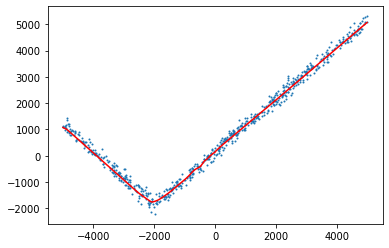

In [37]:
from matplotlib import pyplot
pyplot.plot(line_x, line_y, 'r')
pyplot.scatter(x,y,s=1)
pyplot.show()

In [38]:
predictor.delete_endpoint()

Gracefully stopping... (press Ctrl+C again to force)
